In [2]:
from Korpora import Korpora
from konlpy.tag import Okt, Kkma
import spacy
from collections import Counter

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

from sklearn.model_selection import train_test_split

import pandas as pd
import re

MODULE_PATH = '/Users/anhyojun/WorkSpace/KDT2/MyModule'
import sys
sys.path.append(MODULE_PATH)
from KDTModule import *

## 1. 데이터 불러오기

In [3]:
# NSMC 데이터 불러오기
nsmc = Korpora.load('nsmc')


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : e9t@github
    Repository : https://github.com/e9t/nsmc
    References : www.lucypark.kr/docs/2015-pyconkr/#39

    Naver sentiment movie corpus v1.0
    This is a movie review dataset in the Korean language.
    Reviews were scraped from Naver Movies.

    The dataset construction is based on the method noted in
    [Large movie review dataset][^1] from Maas et al., 2011.

    [^1]: http://ai.stanford.edu/~amaas/data/sentiment/

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/

[Korpora] Corpus `nsmc` is already installed at /Users/anhyojun/Korpora/nsmc/ratings_train.txt
[Korpora] Corpus `nsmc` is already installed at /Users/anhy

In [4]:
# 훈련, 테스트 데이터 분리
train_data = nsmc.train
test_data = nsmc.test

train_texts = train_data.texts
train_labels = train_data.labels
test_texts = test_data.texts
test_labels = test_data.labels

In [5]:
# 훈련 검증 데이터 분리
train_texts, valid_texts, train_labels, valid_labels = train_test_split(train_texts, train_labels, test_size = 0.2,
                                                                        stratify = train_labels, random_state = 42)

In [6]:
# 훈련, 검증, 테스트 데이터 길이 확인
print(f"train length : {len(train_texts)}")
print(f"valud length : {len(valid_texts)}")
print(f"test length : {len(test_texts)}")

train length : 120000
valud length : 30000
test length : 50000


## 2. 단어사전 생성

In [7]:
train_voca = build_voca(train_texts)

In [8]:
print(train_voca)

{'<PAD>': 0, '<UNK>': 1, '일본': 2, '투자': 3, '듯': 4, '아버지': 5, '보고싶어': 6, '집니다': 7, '꿀잼': 8, 'ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ': 9, '신선한': 10, '소재': 11, '손': 12, '땀': 13, '쥐': 14, '하는': 15, '긴장감': 16, '최고': 17, '입니다': 18, 'tv': 19, '하길래': 20, '봤는데': 21, '재밌어서': 22, '계속': 23, '영화': 24, '드라마': 25, '있다는게': 26, '행복하다': 27, '완전': 28, '짱': 29, '이세영': 30, '누나': 31, '이쁘고': 32, '짱짱': 33, 'ㅋㅋ': 34, '곽동연': 35, '형': 36, '잘생기고': 37, '곽정욱': 38, '학교': 39, '랑': 40, '반대': 41, '이미지': 42, '진짜': 43, '재밌게': 44, '봤어요': 45, '4': 46, '부작': 47, '이라': 48, '너무': 49, '아쉬운': 50, 'ㅠㅠ': 51, '시청률': 52, '왜': 53, '이리': 54, '낮은지': 55, '아쉽지만': 56, '봣어': 57, '재밌음': 58, '한번': 59, '꼭': 60, '보셈': 61, '안보': 62, '평점': 63, '1': 64, '점': 65, '달지말고': 66, '재미있는': 67, '유머': 68, '초능력': 69, '그것': 70, '밝히려는': 71, '여': 72, '마술사': 73, '이야기': 74, '보따리': 75, '군더더기': 76, '없는': 77, '만화': 78, '캐릭터': 79, '잘': 80, '살린': 81, '제작비': 82, '220억': 83, '이라니깐': 84, '2': 85, '줄': 86, '일단': 87, '졸림': 88, '주인공': 89, '인도': 90, '여행': 91, '려고': 92, '이영화': 93, '캐스팅': 94, '수락': 

## 3. 토큰 텐서화

In [9]:
train_tensor_token_list = make_tensor_token(train_texts, train_voca)
valid_tensor_token_list = make_tensor_token(valid_texts, train_voca)

## 4. 토큰 패딩

In [10]:
def pad_token_tensor(tensor_token_list):
    padded_token_list = []
    for token in tensor_token_list:
        padded_token_list.append(pad_sequence(token, 10))
    padded_token_tensor = torch.stack(padded_token_list)

    return padded_token_tensor

In [11]:
train_padded_token_tensor = pad_token_tensor(train_tensor_token_list)
valid_padded_token_tensor = pad_token_tensor(valid_tensor_token_list)

In [12]:
train_padded_token_tensor

tensor([[    2,     3,     4,  ...,     0,     0,     0],
        [    5,     6,     7,  ...,     0,     0,     0],
        [    8,     9,     0,  ...,     0,     0,     0],
        ...,
        [ 1400,    24,   121,  ...,   987,  2441,   197],
        [  735,    65,  5448,  ...,     0,     0,     0],
        [ 1540,   277,  3088,  ...,  2057, 10001, 49104]])

In [13]:
valid_padded_token_tensor

tensor([[  725,   644,   230,  ...,     0,     0,     0],
        [ 7594,   162,   503,  ...,     0,     0,     0],
        [ 2260,    24,     0,  ...,     0,     0,     0],
        ...,
        [   96,   839,   518,  ..., 23569, 65764,    96],
        [ 3339,   155,  2007,  ...,     0,     0,     0],
        [ 8221, 51394,  3715,  ...,     0,     0,     0]])

In [14]:
train_labels_2D = [[label] for label in train_labels]
valid_labels_2D = [[label] for label in valid_labels]

## 5. 커스텀 데이터셋 생성

In [15]:
# 데이터셋 생성
trainDS = TextDataset(train_padded_token_tensor, train_labels_2D)
validDS = TextDataset(valid_padded_token_tensor, valid_labels_2D)

# 데이터로더 생성
trainDL = DataLoader(trainDS, batch_size = 16)
validDL = DataLoader(validDS, batch_size = 16)

In [16]:
trainDL.dataset[0]

(tensor([2, 3, 4, 0, 0, 0, 0, 0, 0, 0]), tensor([0.]))

## 6. 손실함수, 최적화 함수 정의

In [17]:
# MPS 사용 여부 확인하기
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"device : {device}")

device : mps


In [42]:
# n_vocab = len(train_voca)
# hidden_dim = 64
# embedding_dim = 128
# n_layers = 2

# model = SentenceClassifier(n_vocab=n_vocab, hidden_dim=hidden_dim, embedding_dim=embedding_dim, n_layers=n_layers)

# optimizer = optim.RMSprop(model.parameters(), lr = 0.001)

# # 모델 훈련
# EPOCH = 10
# SAVE_PATH = '/Users/anhyojun/WorkSpace/KDT2/김소현 강사님/TORCH_NLP/숙제/model_1008'
# result = training(trainDL, validDL, model, 'binary', optimizer, EPOCH, 3, 1, 1, SAVE_PATH)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/10] Train : 0.4671, Test : 0.4149
[Score  : 1/10] Train : 0.7529, Test : 0.7968
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/10] Train : 0.3546, Test : 0.3956
[Score  : 2/10] Train : 0.8297, Test : 0.8094
[Loss : 3/10] Train : 0.2877, Test : 0.4102
[Score  : 3/10] Train : 0.8691, Test : 0.8106
[Loss : 4/10] Train : 0.2270, Test : 0.4428
[Score  : 4/10] Train : 0.9023, Test : 0.8062
[Loss]값의 개선이 이루어지지 않아 [5] EPOCH에서 학습을 종료합니다.


In [23]:
n_vocab = len(train_voca)
hidden_dim = 64
embedding_dim = 128
n_layers = 2

model = SentenceClassifier(n_vocab=n_vocab, hidden_dim=hidden_dim, embedding_dim=embedding_dim, n_layers=n_layers)

optimizer = optim.RMSprop(model.parameters(), lr = 0.001)

# 모델 훈련
EPOCH = 10
SAVE_PATH = '/Users/anhyojun/WorkSpace/KDT2/김소현 강사님/TORCH_NLP/숙제/model_1008'
result = training(trainDL, validDL, model, 'binary', optimizer, EPOCH, 3, 1, 1, SAVE_PATH, MPS=True, device=device)

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got MPSFloatType instead (while checking arguments for embedding)

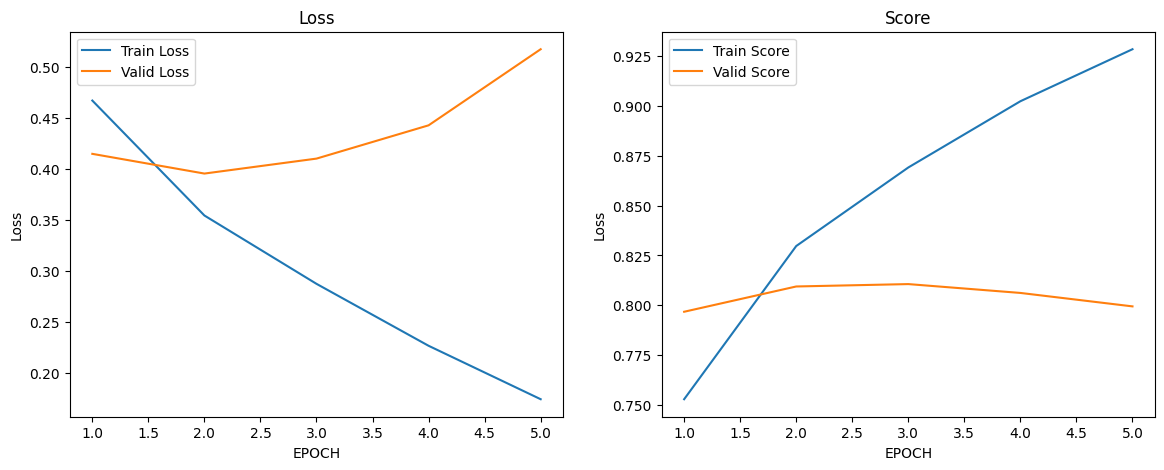

In [52]:
DrawPlot(result)
plt.show()

In [45]:
n_vocab = len(train_voca)
hidden_dim = 64
embedding_dim = 128
n_layers = 2

best_model = SentenceClassifier(n_vocab=n_vocab, hidden_dim=hidden_dim, embedding_dim=embedding_dim, n_layers=n_layers)

optimizer = optim.RMSprop(model.parameters(), lr = 0.001)

In [47]:
best_model.load_state_dict(torch.load('best_model_epoch_2.pth', weights_only=True))

<All keys matched successfully>

In [111]:
test_tensor_token_list = make_tensor_token(test_texts, train_voca)
test_tensor_token_list

[tensor([2399, 1528]),
 tensor([1]),
 tensor([  321,   668,    63, 21022,  2417,   503,    65,  2317,  1544,   532,
          3513]),
 tensor([35725,  4750,    28,  1443,   409,   859,   967,   192]),
 tensor([  832,  8932, 36092,   735, 11464, 29856,    53,   832,  8932,  5405,
          4097, 17310,  7685,  2673]),
 tensor([  562, 12822,    17,   562,    24]),
 tensor([2997,  279]),
 tensor([  200,  1490,     1, 10610,    77,  5103,   437,  2221,  6685, 43524,
           440]),
 tensor([ 3896,  5646, 30034,  8439,  3171,   573,  1366,   775, 13127, 16084,
          1025,  1900,  5516,  1601,     1,  8271, 35163,   314,    24,   832,
          4539,  1426]),
 tensor([ 4038,   335,   318, 32506,  4535,  8175, 14466, 14057,   474,   125,
             1,  2974]),
 tensor([ 3727,  1112, 40763, 41929]),
 tensor([ 996, 3359, 5370,  961,    5,    1, 3306]),
 tensor([ 1484,  2687,  7021, 12003, 19811, 16458, 35784,  7021,    80, 31891,
           929,   164, 29790,   314,  5679,    24]),
 ten

In [114]:
test_padded_token_tensor = pad_token_tensor(test_tensor_token_list)
test_padded_token_tensor, test_padded_token_tensor.shape

(tensor([[ 2399,  1528,     0,  ...,     0,     0,     0],
         [    1,     0,     0,  ...,     0,     0,     0],
         [  321,   668,    63,  ...,  2317,  1544,   532],
         ...,
         [ 5487,   393,  2237,  ..., 28264,  3616,     0],
         [  697,  1417,  2908,  ...,  2092,  1683,  3866],
         [ 1344,   286,    53,  ...,     0,     0,     0]]),
 torch.Size([50000, 10]))

In [122]:
test_label_tensor = torch.tensor(test_labels, dtype=torch.float).unsqueeze(1)
test_label_tensor, test_label_tensor.shape

(tensor([[1.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]),
 torch.Size([50000, 1]))

In [126]:
pred_logit = best_model(test_padded_token_tensor)
pred_logit

tensor([[ 2.6553],
        [ 0.3402],
        [ 1.2579],
        ...,
        [ 1.1940],
        [-4.8785],
        [-1.6414]], grad_fn=<AddmmBackward0>)

In [128]:
pred_prob = F.sigmoid(pred_logit)
pred_prob

tensor([[0.9343],
        [0.5842],
        [0.7787],
        ...,
        [0.7675],
        [0.0076],
        [0.1623]], grad_fn=<SigmoidBackward0>)

In [131]:
pred_value = pred_prob.round()
pred_value

tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [0.],
        [0.]], grad_fn=<RoundBackward0>)

In [143]:
f1 = f1_score(pred_value, test_label_tensor, task='binary').item()
f1

0.8148309588432312

In [140]:
accuracy = ((pred_value == test_label_tensor).sum() / len(pred_value)).item()
accuracy

0.8130199909210205

In [144]:
loss = F.binary_cross_entropy(pred_prob, test_label_tensor).item()
loss

0.4043675661087036

In [145]:
print(f"test accuracy : {accuracy:.4f}")
print(f"test score : {f1:.4f}")
print(f"test loss : {loss:.4f}")

test accuracy : 0.8130
test score : 0.8148
test loss : 0.4044
